In [196]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import logging
import numpy as np
import torchvision , torcheval
import random,math
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import fastcore.all as fc
import torch.optim as optim
from operator import attrgetter
from functools import partial
from datasets import load_dataset,load_dataset_builder
from torch.utils.data import DataLoader,default_collate,Dataset
from torcheval.metrics import MulticlassAccuracy,Mean
from copy import copy
from torch.optim.lr_scheduler import ExponentialLR
from collections.abc import Mapping
from fastprogress import progress_bar,master_bar
from diffusers import UNet2DModel
from torch.optim.lr_scheduler import ExponentialLR
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

In [157]:
# Get the device
def_device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Function to send data to device
def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

In [158]:
# Load the datasets
# Remember to pad the images with 2 pixels on each side i.e. to make the image size 32x32

batch_size = 1024

transforms = T.Compose([T.ToTensor(),T.Pad(2)])

train_ds = torchvision.datasets.FashionMNIST(root = './data/train',train = True,download = True,transform = transforms)
valid_ds = torchvision.datasets.FashionMNIST(root = './data/valid',train = False,download = True,transform = transforms)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=4)

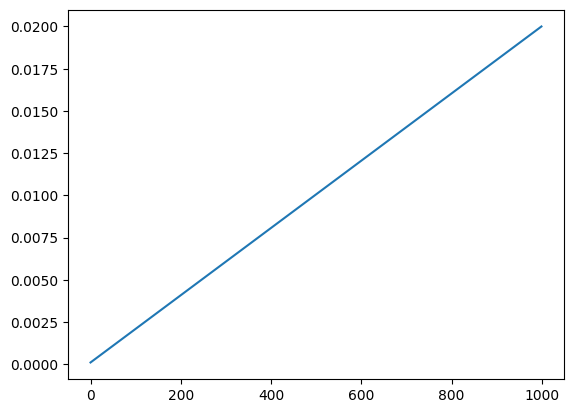

In [159]:
beta_min = 0.0001
beta_max = 0.02
n_steps = 1000
beta = torch.linspace(beta_min, beta_max, n_steps)
alpha = 1. - beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [ ]:
plt.plot(beta)

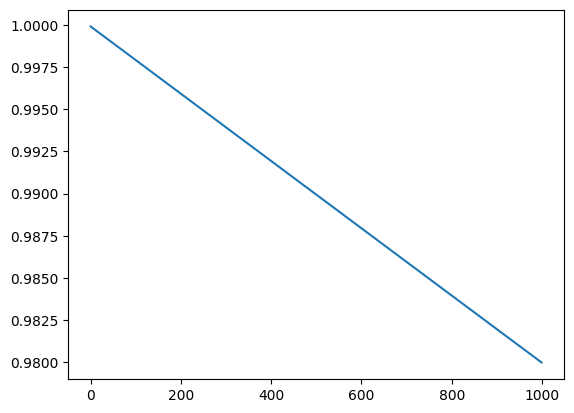

In [160]:
plt.plot(alpha)

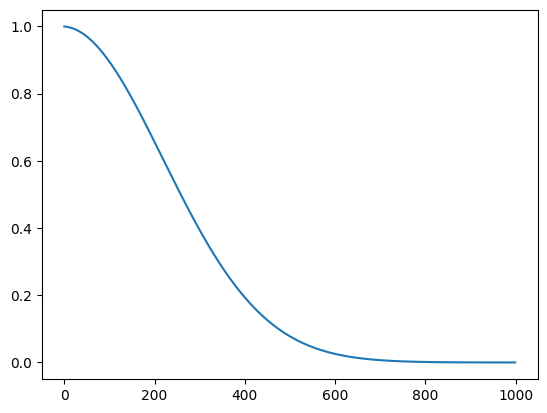

In [161]:
plt.plot(alphabar)

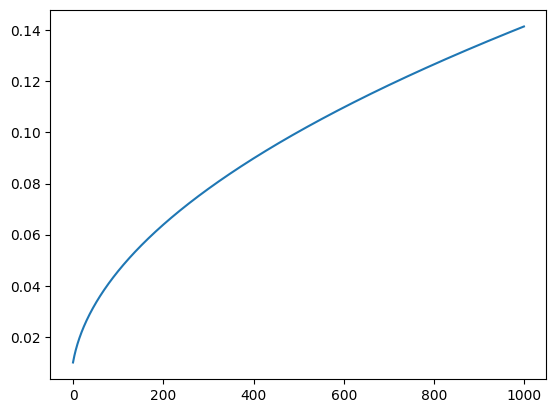

In [162]:
plt.plot(sigma)

In [163]:
def add_noise(x_0, alphabar):
    device = x_0.device
    n = len(x_0)
    timesteps = torch.randint(0, n_steps, (n,), device=device)
    alphabar_t = alphabar[timesteps].reshape(-1, 1, 1, 1).to(device)
    noise = torch.randn_like(x_0, device=device)
    x_t = x_0 * alphabar_t.sqrt() + (1. - alphabar_t).sqrt()* noise
    return (x_t, timesteps.to(device)), noise

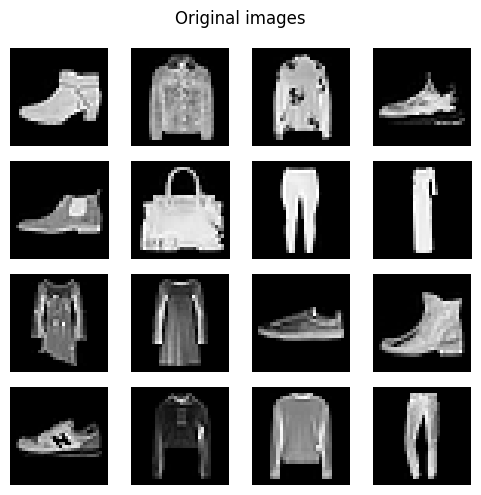

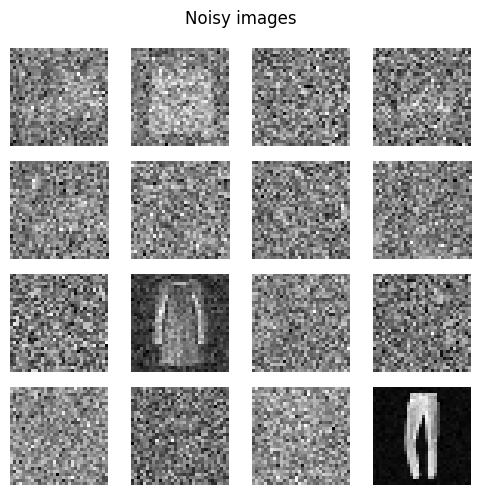

tensor([263, 129, 798, 282, 290, 987, 597, 628, 516,  29, 671, 600, 964, 641,
        458,   2])


In [197]:
batch = next(iter(train_dl))
x_0 = batch[0][:16]
(x_t, timesteps), noise = add_noise(x_0, alphabar)

plt.figure(figsize=(5, 5))
plt.suptitle('Original images')
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_0[i, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.suptitle('Noisy images')
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_t[i, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

print(timesteps)

In [192]:
class DDPM_model(nn.Module):
    def __init__(self, model, beta_min, beta_max, n_steps):
        super().__init__()
        self.model = model
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.n_steps = n_steps
        self.beta = torch.linspace(beta_min, beta_max, n_steps)
        self.alpha = 1. - self.beta
        self.alphabar = self.alpha.cumprod(dim=0)
        self.sigma = self.beta.sqrt()

    def add_noise(self, x_0):
        device = x_0.device
        n = len(x_0)
        timesteps = torch.randint(0, n_steps, (n,), device=device)
        alphabar_t = self.alphabar[timesteps].reshape(-1, 1, 1, 1).to(device)
        noise = torch.randn_like(x_0, device=device)
        x_t = x_0 * alphabar_t.sqrt() + (1. - alphabar_t).sqrt()* noise
        return (x_t, timesteps.to(device)), noise

    def forward(self, x):
        return self.model.forward(*x).sample
    
    @torch.no_grad()
    def sample(self,sz):
        device = next(self.model.parameters()).device
        x_t = torch.randn(sz, device=device)
        preds = []
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            alpha_t = self.alpha[t]
            alphabar_t = self.alphabar[t]
            sigma_t = self.sigma[t]
            x_t = (x_t - (1-alpha_t)/((1-alphabar_t).sqrt())*self.model.forward(x_t, t_batch).sample)/(alpha_t.sqrt()) + sigma_t*z
            preds.append(x_t.cpu())
        return preds
    
    @torch.no_grad()
    def sample_skip(self, sz):
        ps = next(self.model.parameters())
        x_t = torch.randn(sz).to(ps)
        preds = []
        for t in reversed(range(n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
            ᾱ_t1 = self.alphabar[t-1]  if t > 0 else torch.tensor(1)
            b̄_t = 1-self.alphabar[t]
            b̄_t1 = 1-ᾱ_t1
            if t%3==0 or t<50: noise = self.model(x_t, t_batch).sample
            x_0_hat = ((x_t - b̄_t.sqrt() * noise)/self.alphabar[t].sqrt())
            x_t = x_0_hat * ᾱ_t1.sqrt()*(1-self.alpha[t])/b̄_t + x_t * self.alpha[t].sqrt()*b̄_t1/b̄_t + self.sigma[t]*z
            preds.append(x_t.cpu().float())
        return preds

In [166]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * model((x_t, t_batch)))/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu())
    return preds

In [167]:
@torch.no_grad()
def sample2(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    sample_at = {t for t in range(n_steps) if (t+101)%((t+101)//100)==0}
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        if t in sample_at: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        if t in sample_at: preds.append(x_t.float().cpu())
    return preds

In [169]:
unet_model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128),norm_num_groups=8)
model = DDPM_model(unet_model, 0.0001, 0.02, 1000)

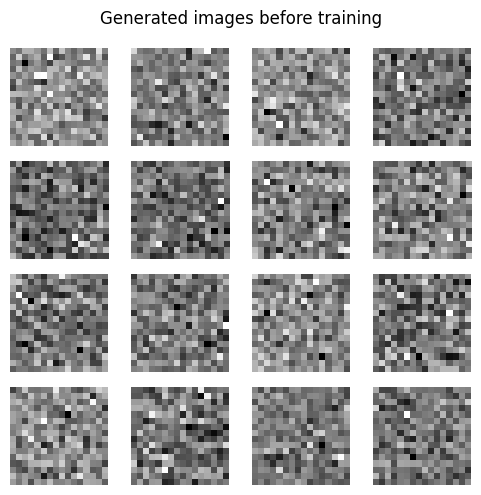

In [171]:
preds = model.sample((32, 1, 16, 16))

plt.figure(figsize=(5, 5))
plt.suptitle("Generated images before training")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(preds[-1][i, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [172]:
epochs = 5
lr = 0.001
opt = optim.Adam(model.parameters(), lr=lr,eps = 1e-5)
sched = optim.lr_scheduler.OneCycleLR(opt, lr, epochs=epochs, steps_per_epoch=len(train_dl))

In [173]:
def fit(model,train_dl,valid_dl,loss_func,epochs,opt,sched):
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(epochs):
        losses = []
        model.train()
        for xb,_ in train_dl:
            opt.zero_grad()
            xb = to_device(xb)
            (x_t, timesteps), noise = model.add_noise(xb)
            (x_t, timesteps) = to_device((x_t, timesteps))
            noise = to_device(noise)
            with torch.cuda.amp.autocast(dtype=torch.float16):
                preds = model((x_t, timesteps))
                loss = loss_func(preds, noise)
            losses.append(loss.item() * len(xb))
            scaler.scale(loss).backward()
            scaler.step(opt)
            sched.step()
            scaler.update()
        print(f"Epoch {epoch} train loss: {sum(losses)/len(train_ds)}")
        model.eval()
        losses = []
        with torch.no_grad():
            for xb,_ in valid_dl:
                xb = to_device(xb)
                (x_t, timesteps), noise = add_noise(xb, model.alphabar)
                (x_t, timesteps) = to_device((x_t, timesteps))
                noise = to_device(noise)
                preds = model((x_t, timesteps))
                loss = loss_func(preds, noise)
                losses.append(loss.item() * len(xb))
        print(f"Epoch {epoch} valid loss: {sum(losses)/len(valid_ds)}")

In [174]:
# fit(model.to(def_device),train_dl,valid_dl,F.mse_loss,epochs,opt,sched)

In [175]:
# model = model.cpu()
# torch.save(model.state_dict(),"DDPM_state_dict.pth")
# torch.save(model,"DDPM.pth")
# torch.save(model.model,"DDPM_unet.pth")
# torch.save(model.model.state_dict(),"DDPM_unet_state_dict.pth")

In [194]:
model = DDPM_model(unet_model, 0.0001, 0.02, 1000)
model.load_state_dict(torch.load("DDPM_state_dict.pth",map_location=torch.device('cpu')))

<All keys matched successfully>

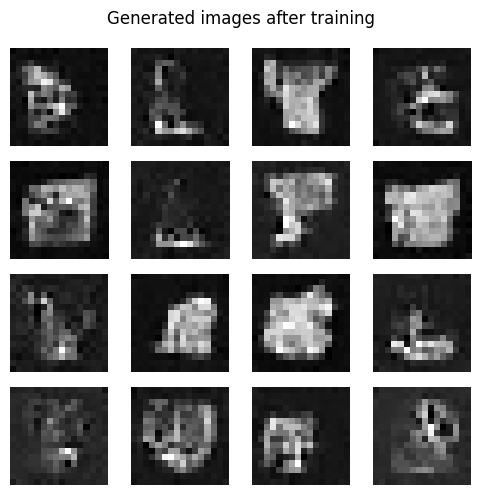

In [177]:
preds = model.sample((32, 1, 16, 16))

plt.figure(figsize=(5, 5))
plt.suptitle("Generated images after training")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(preds[-1][i, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

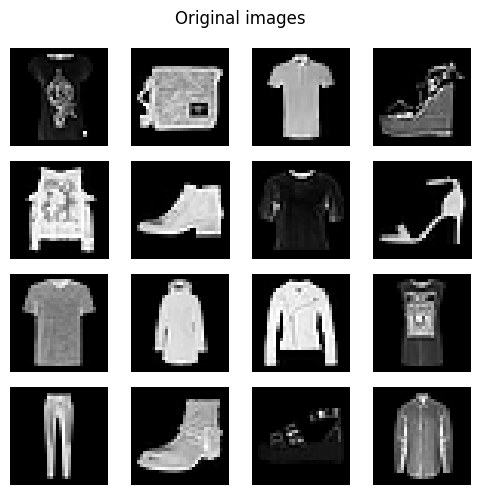

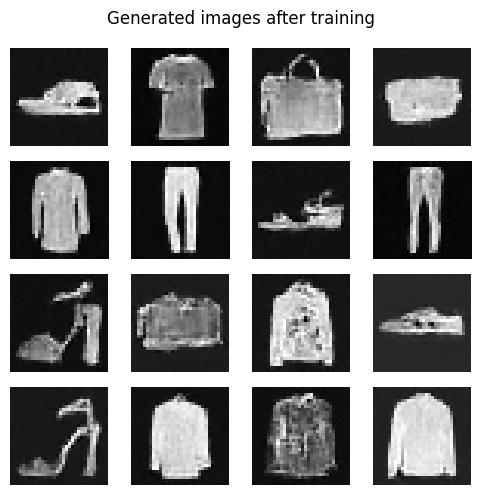

In [178]:
batch = next(iter(train_dl))
x_0 = batch[0][:16]

plt.figure(figsize=(5, 5))
plt.suptitle('Original images')
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_0[i, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

preds = sample(model, (16,1,32,32), alpha, alphabar, sigma, n_steps)

plt.figure(figsize=(5, 5))
plt.suptitle("Generated images after training")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(preds[-1][i, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

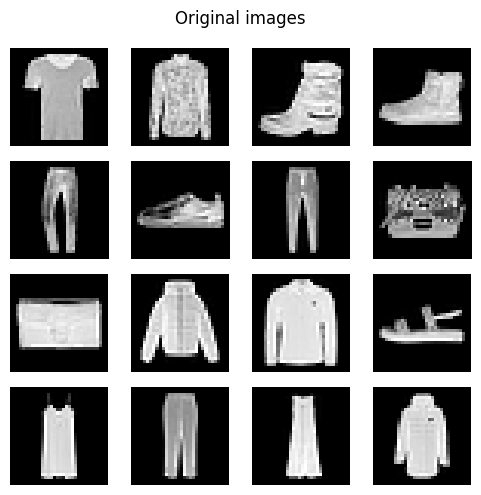

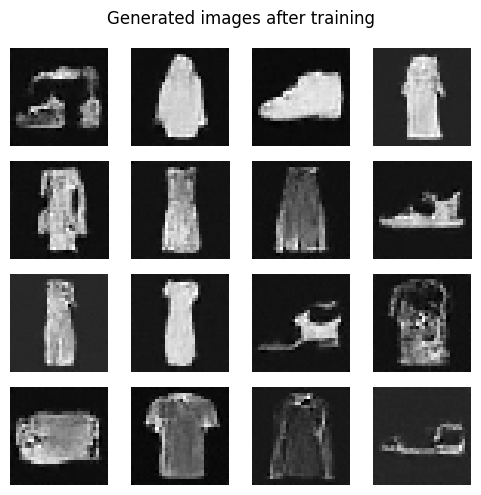

In [195]:
batch = next(iter(train_dl))
x_0 = batch[0][:16]

plt.figure(figsize=(5, 5))
plt.suptitle('Original images')
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_0[i, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

preds = model.sample_skip((16,1,32,32))

plt.figure(figsize=(5, 5))
plt.suptitle("Generated images using skip sampling")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(preds[-1][i, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()